In [ ]:
!pip install wandb
!wandb login

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from PIL import Image, ImageOps
from skimage.metrics import structural_similarity as ssim

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os

from tensorflow.keras.datasets import fashion_mnist, cifar10

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
input_sizes_dict = {
    'm': 28,
    'c': 32,
}
channels_dict = {
    'm': 1,
    'c': 3,
}

In [ ]:
def fit_model_and_log_metrics(run_name, run_notes, model, epochs, batch_size):
    run = wandb.init(project="autoencoders_conv", entity="csc2231-yash-siphelele", name=run_name, notes=run_notes)
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, x_test), callbacks=[WandbCallback()]) 
    decoded_imgs = model.predict(x_test)
    ssim_scores = []
    for i in range(len(x_test)):
        if CURRENT_DATASET_TYPE == 'c':
            ssim_value = ssim(x_test[i].reshape(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE], channels_dict[CURRENT_DATASET_TYPE]), 
                                            decoded_imgs[i].reshape(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE], channels_dict[CURRENT_DATASET_TYPE]),
                              multichannel=True)
        else:
            ssim_value = ssim(x_test[i].reshape(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE]), 
                                            decoded_imgs[i].reshape(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE]))
        ssim_scores.append(ssim_value)

    avg_ssim_score_x_test = np.mean(ssim_scores)
    wandb.log({"avg_ssim_score_x_test": avg_ssim_score_x_test})
    print("Avg SSIM over X_test:", avg_ssim_score_x_test)
    run.finish()

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

170508288/170498071 [==============================] - 11s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [ ]:
Z_DIM = [20, 100, 300, 5000]  # Dimension of the latent vector (z), model is trained using different values of Z_DIM

In [ ]:
CURRENT_DATASET_TYPE = 'c'

In [ ]:
# Model 10

def Encoder(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(channels_dict[CURRENT_DATASET_TYPE], (3, 3), padding='same')(x)
    return decoded


# input 
input = Input(shape=(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE], channels_dict[CURRENT_DATASET_TYPE])) 


# make encoder
encoder = Encoder(input)
volume_size = K.int_shape(encoder)
flatten = Flatten()(encoder)
encoder_output = Dense(Z_DIM[0])(flatten)
encoder = Model(input, encoder_output)
print("Encoder model summary:")
encoder.summary()
print("_-_" * 43)
print()


# make decoder
decode_input = Input(shape=(Z_DIM[0],))
decode_x = Dense(np.prod(volume_size[1:]))(decode_input)
decode_x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(decode_x)
decoder_output = Decoder(decode_x)
decoder = Model(decode_input, decoder_output)
print("Decoder model summary:")
decoder.summary()
print("_-_" * 43)
print()


# make autoencoder model
autoencoder = Model(input, decoder(encoder(input)))
autoencoder.compile(optimizer = "adam", loss = "mse")
print("Autoencoder ensemble summary:")
autoencoder.summary()

Encoder model summary:
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 16)          4624      
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 8)           1160      
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 20)                10260     
                                                                 
Total params: 16,940
Trainable para

In [ ]:
# fit the autoencoder model
fit_model_and_log_metrics("Model 7_c", "With maxpooling, convtranspose, dense, and flatten", autoencoder, epochs=75, batch_size=256)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,74
best_val_loss,0.01552
epoch,74
loss,0.01551
val_loss,0.01552


Epoch 1/75
196/196 [==============================] - 5s 21ms/step - loss: 0.0547 - val_loss: 0.0281 - _timestamp: 1648490300.0000 - _runtime: 11.0000
Epoch 2/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0232 - val_loss: 0.0208 - _timestamp: 1648490303.0000 - _runtime: 14.0000
Epoch 3/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0200 - val_loss: 0.0196 - _timestamp: 1648490307.0000 - _runtime: 18.0000
Epoch 4/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0192 - val_loss: 0.0192 - _timestamp: 1648490310.0000 - _runtime: 21.0000
Epoch 5/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0188 - val_loss: 0.0188 - _timestamp: 1648490314.0000 - _runtime: 25.0000
Epoch 6/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0186 - val_loss: 0.0186 - _timestamp: 1648490317.0000 - _runtime: 28.0000
Epoch 7/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0185 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.54162
best_epoch,74
best_val_loss,0.01555
epoch,74
loss,0.01553
val_loss,0.01555


In [ ]:
# Model 10

def Encoder(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(channels_dict[CURRENT_DATASET_TYPE], (3, 3), padding='same')(x)
    return decoded


# input 
input = Input(shape=(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE], channels_dict[CURRENT_DATASET_TYPE])) 


# make encoder
encoder = Encoder(input)
volume_size = K.int_shape(encoder)
flatten = Flatten()(encoder)
encoder_output = Dense(Z_DIM[2])(flatten)
encoder = Model(input, encoder_output)
print("Encoder model summary:")
encoder.summary()
print("_-_" * 43)
print()


# make decoder
decode_input = Input(shape=(Z_DIM[2],))
decode_x = Dense(np.prod(volume_size[1:]))(decode_input)
decode_x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(decode_x)
decoder_output = Decoder(decode_x)
decoder = Model(decode_input, decoder_output)
print("Decoder model summary:")
decoder.summary()
print("_-_" * 43)
print()


# make autoencoder model
autoencoder = Model(input, decoder(encoder(input)))
autoencoder.compile(optimizer = "adam", loss = "mse")
print("Autoencoder ensemble summary:")
autoencoder.summary()


# fit the autoencoder model
fit_model_and_log_metrics("Model 7.3_c", "With maxpooling, convtranspose, dense, and flatten", autoencoder, epochs=75, batch_size=256)

Encoder model summary:
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 16)          4624      
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 8)           1160      
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               51300     
                                                                 
Total params: 57,980
Trainable para

Epoch 1/75
196/196 [==============================] - 5s 21ms/step - loss: 0.0499 - val_loss: 0.0207 - _timestamp: 1648490593.0000 - _runtime: 10.0000
Epoch 2/75
196/196 [==============================] - 4s 19ms/step - loss: 0.0177 - val_loss: 0.0158 - _timestamp: 1648490596.0000 - _runtime: 13.0000
Epoch 3/75
196/196 [==============================] - 4s 18ms/step - loss: 0.0151 - val_loss: 0.0144 - _timestamp: 1648490600.0000 - _runtime: 17.0000
Epoch 4/75
196/196 [==============================] - 4s 19ms/step - loss: 0.0142 - val_loss: 0.0142 - _timestamp: 1648490604.0000 - _runtime: 21.0000
Epoch 5/75
196/196 [==============================] - 4s 19ms/step - loss: 0.0136 - val_loss: 0.0133 - _timestamp: 1648490607.0000 - _runtime: 24.0000
Epoch 6/75
196/196 [==============================] - 4s 19ms/step - loss: 0.0122 - val_loss: 0.0107 - _timestamp: 1648490611.0000 - _runtime: 28.0000
Epoch 7/75
196/196 [==============================] - 4s 19ms/step - loss: 0.0103 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.80766
best_epoch,74
best_val_loss,0.00592
epoch,74
loss,0.00593
val_loss,0.00592


In [ ]:
# Model 11

def Encoder(input_img):
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same', strides=2)(input_img)
    x = Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2)(x)
    encoded = Conv2D(8, (3, 3), activation='leaky_relu', padding='same')(x)
    return encoded

def Decoder(encoded):
    x = Conv2DTranspose(16, (3, 3), strides = 2, activation='leaky_relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides = 2, activation='leaky_relu', padding='same')(x)
    decoded = Conv2D(channels_dict[CURRENT_DATASET_TYPE], (3, 3), padding='same')(x)
    return decoded


# input 
input = Input(shape=(input_sizes_dict[CURRENT_DATASET_TYPE], input_sizes_dict[CURRENT_DATASET_TYPE], channels_dict[CURRENT_DATASET_TYPE])) 


# make encoder
encoder = Encoder(input)
volume_size = K.int_shape(encoder)
flatten = Flatten()(encoder)
encoder_output = Dense(Z_DIM[2])(flatten)
encoder = Model(input, encoder_output)
print("Encoder model summary:")
encoder.summary()
print("_-_" * 43)
print()


# make decoder
decode_input = Input(shape=(Z_DIM[2],))
decode_x = Dense(np.prod(volume_size[1:]))(decode_input)
decode_x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(decode_x)
decoder_output = Decoder(decode_x)
decoder = Model(decode_input, decoder_output)
print("Decoder model summary:")
decoder.summary()
print("_-_" * 43)
print()


# make autoencoder model
autoencoder = Model(input, decoder(encoder(input)))
autoencoder.compile(optimizer = "adam", loss = "mse")
print("Autoencoder ensemble summary:")
autoencoder.summary()


# fit the autoencoder model
fit_model_and_log_metrics("Model 7.2_c", "With maxpooling, convtranspose, dense, and flatten", autoencoder, epochs=75, batch_size=256)

Encoder model summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 8)           1160      
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               153900    
                                                                 
Total params: 160,580
Trainable para

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
best_epoch,39
best_val_loss,0.00626
epoch,40
loss,0.00627
val_loss,0.00626


Epoch 1/75
196/196 [==============================] - 9s 40ms/step - loss: 0.0456 - val_loss: 0.0176 - _timestamp: 1648659165.0000 - _runtime: 15.0000
Epoch 2/75
196/196 [==============================] - 7s 38ms/step - loss: 0.0148 - val_loss: 0.0117 - _timestamp: 1648659173.0000 - _runtime: 23.0000
Epoch 3/75
196/196 [==============================] - 7s 38ms/step - loss: 0.0104 - val_loss: 0.0093 - _timestamp: 1648659180.0000 - _runtime: 30.0000
Epoch 4/75
196/196 [==============================] - 7s 38ms/step - loss: 0.0088 - val_loss: 0.0082 - _timestamp: 1648659187.0000 - _runtime: 37.0000
Epoch 5/75
196/196 [==============================] - 7s 37ms/step - loss: 0.0079 - val_loss: 0.0077 - _timestamp: 1648659195.0000 - _runtime: 45.0000
Epoch 6/75
196/196 [==============================] - 7s 38ms/step - loss: 0.0074 - val_loss: 0.0070 - _timestamp: 1648659202.0000 - _runtime: 52.0000
Epoch 7/75
196/196 [==============================] - 7s 38ms/step - loss: 0.0068 - val_loss: 

avg_ssim_score_x_test,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_score_x_test,0.91257
best_epoch,73
best_val_loss,0.00257
epoch,74
loss,0.00259
val_loss,0.00257


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


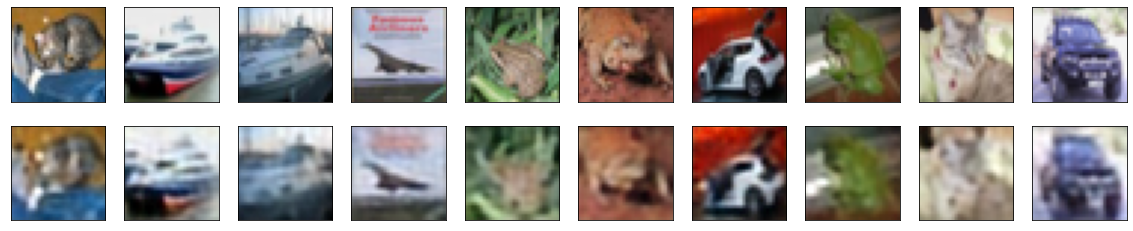

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(32, 32, 3))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show() 